In [22]:
from qiskit import QuantumCircuit, transpile
#from qiskit_aer.primitives import Estimator as local_estimator
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import RZGate
from qiskit.quantum_info import Operator
import numpy as np
import json
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Pauli
import os
import matplotlib.pyplot as plt
import itertools
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import DensityMatrix, partial_trace, Operator
import numpy as np

import Create_quantum_circuit
import Manipulate_layers
import time
import local_projection_computation
import Checking_Equivalence_with_Choi

## Layer-by-Layer Circuit Construction for the benchmarking in Figure 4

In this section, we **construct the circuit layer by layer** to reproduce the experiment corresponding to **Figure 4** in the paper.

For reference, you may consult the notebook:  `micro_benchmark_FIG_3.ipynb`  to see how such circuits are built in a more structured manner.

 **Note**: This micro-benchmark requires **less runtime** compared to the one used in **Figure 3** since we deal with a circuit of depth 5 only.

---

### Gate Placement

The **CONTROL-U-CONTROL** gate is applied on qubits **(0, 1, 2)** within a **20-qubit circuit**.

---

###  Execution Order

Please **run the notebook blocks in sequence**. Re-running any block will **trigger re-execution** of all subsequent steps, including those that may be computationally intensive.

## We now prepare gate U, V and W

In [23]:
A_00 = np.array([[1,0],[0,0]])
A_01 = np.array([[0,1],[0,0]])
A_10 = np.array([[0,0],[1,0]])
A_11 = np.array([[0,0],[0,1]])
# print("A_00 (Top-left block):")
# print(A_00)
# print("\nA_01 (Top-right block):")
# print(A_01)
# print("\nA_10 (Bottom-left block):")
# print(A_10)
# print("\nA_11 (Bottom-right block):")
# print(A_11)
np.set_printoptions(linewidth=200)
# control_W = np.kron(A_00,np.eye(2))+np.kron(A_11,W)
# print("Control W matrix:")
# print(control_W)

In [24]:
import numpy as np

j = 1j  # imaginary unit

# Sample theta1 and theta2 uniformly from [-π, π]
# theta1 = np.random.uniform(-np.pi, np.pi)
# theta2 = np.random.uniform(-np.pi, np.pi)
theta = np.random.uniform(-np.pi, np.pi)
# Construct the diagonal unitary matrix
U = np.array([[np.exp(-j * theta), 0],
              [0, np.exp(j * theta)]])

print(U)

[[-0.77168881+0.6360003j  0.        +0.j       ]
 [ 0.        +0.j        -0.77168881-0.6360003j]]


## We have $W^2=U$ as below

In [25]:
W = np.diag([np.exp(-j * theta/2),np.exp(j * theta/2)])
print("W matrix:\n",W)
print("W @ W:\n",W@W)
print("U matrix:\n",U)
V = np.array([[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,0,1]])
V = np.array([[0,1,0,0],[1,0,0,0],[0,0,1,0],[0,0,0,1]])
# print(U_BC)
print("V matrix:\n",V)


W matrix:
 [[0.3378692+0.94119307j 0.       +0.j        ]
 [0.       +0.j         0.3378692-0.94119307j]]
W @ W:
 [[-0.77168881+0.6360003j  0.        +0.j       ]
 [ 0.        +0.j        -0.77168881-0.6360003j]]
U matrix:
 [[-0.77168881+0.6360003j  0.        +0.j       ]
 [ 0.        +0.j        -0.77168881-0.6360003j]]
V matrix:
 [[0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]]


## We prepare the control-U-Control gate, denoted as CCU. The control qubits are the 1st and the 3rd ones

In [26]:
CCU = np.eye(8)-np.kron(np.kron(A_11,np.eye(2)-U),A_11) # This control gate controls the first and the third qubit
print(CCU)
np.savetxt("read_matrix.txt", CCU, fmt="%.3f")

[[ 1.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         1.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         0.        +0.j         1.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         0.        +0.j         0.        +0.j         1.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j         1.        +0.j         0.        +0.j         0.        +0.j         0.        +0.j       ]
 [ 0.        +0.j         0.        +0.j         0.        +0.j  

## Prepare control-W where the control qubit is the second

In [27]:
control_W = np.kron(np.eye(2),A_00)+np.kron(W,A_11)
print(control_W)

[[1.       +0.j         0.       +0.j         0.       +0.j         0.       +0.j        ]
 [0.       +0.j         0.3378692+0.94119307j 0.       +0.j         0.       +0.j        ]
 [0.       +0.j         0.       +0.j         1.       +0.j         0.       +0.j        ]
 [0.       +0.j         0.       +0.j         0.       +0.j         0.3378692-0.94119307j]]


## Prepare 

In [28]:
n=10
qc_Deutsch = QuantumCircuit(n*2)
qc_info_Deutsch = []

## Layer 0, add gate $V^\dagger$ and 9 identity gates

{'qubits': [0, 1], 'type': 'unitary', 'matrix': [[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], 'layer': 0}


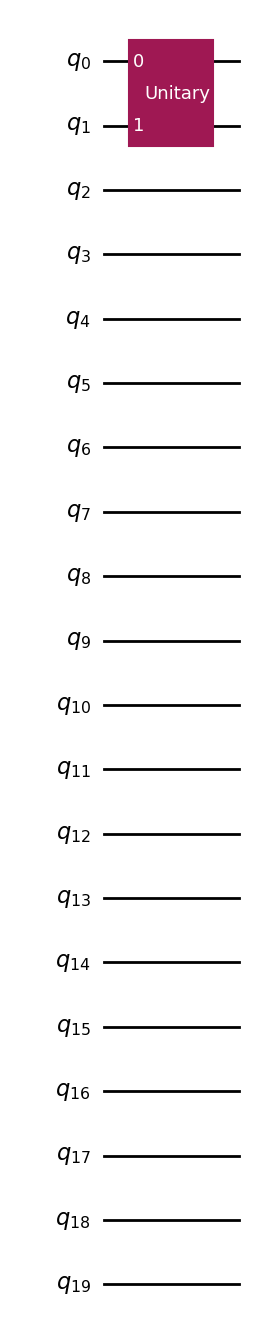

In [29]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[0,1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.transpose(np.conjugate(V))) #   # Add V^\dagger gate
qc_info_Deutsch[-1]['layer'] = 0
# qc_Deutsch, qc_info_Deutsch = Creat_quantum_circuit.add_gate("unitary",[2,3],qc_info_Deutsch,qc_Deutsch,gate_matrix=control_W)
# qc_info_Deutsch[-1]['layer'] = 0
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')


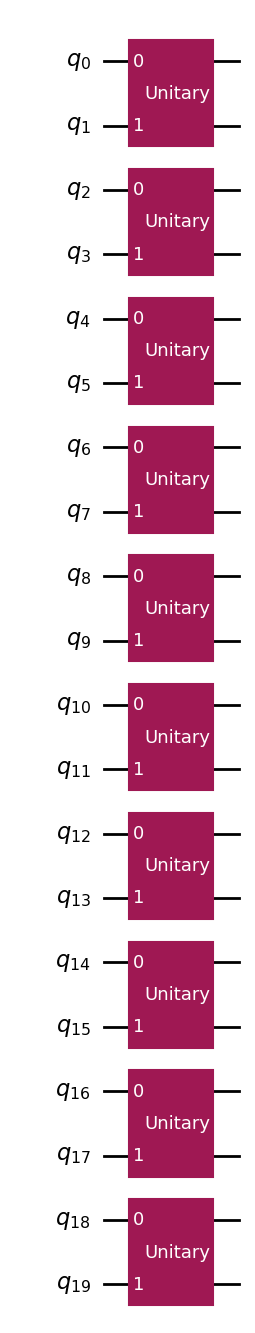

In [30]:
for i in range(1,n):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i,2*i+1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))
    qc_info_Deutsch[-1]['layer'] = 0
qc_Deutsch.draw('mpl')

## Layer 1, Control-W 

{'qubits': [1, 2], 'type': 'unitary', 'matrix': [[(1+0j), 0j, 0j, 0j], [0j, (0.33786920143207105+0.9411930740946061j), 0j, 0j], [0j, 0j, (1+0j), 0j], [0j, 0j, 0j, (0.33786920143207105-0.9411930740946061j)]], 'layer': 1}


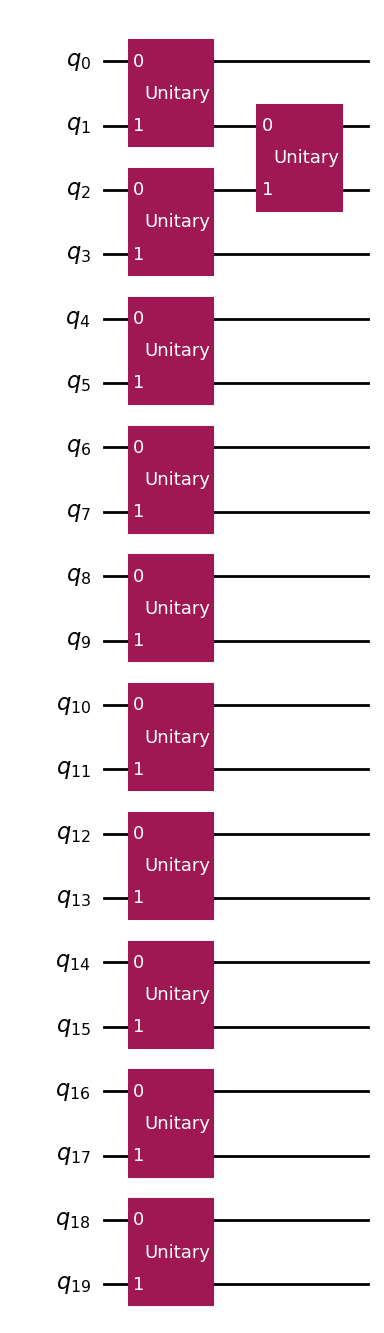

In [31]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[1,2],qc_info_Deutsch,qc_Deutsch,gate_matrix=control_W)
qc_info_Deutsch[-1]['layer'] = 1
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')

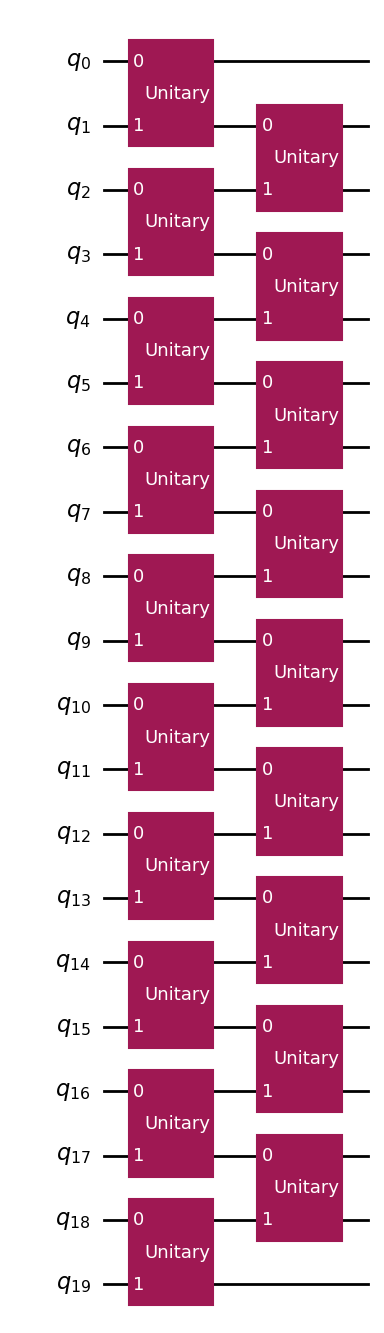

In [32]:
for i in range(1,n-1):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i+1,2*i+2],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4)) # Add identity gates
    qc_info_Deutsch[-1]['layer'] = 1
qc_Deutsch.draw('mpl')

## Layer 2, add gate V

{'qubits': [0, 1], 'type': 'unitary', 'matrix': [[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], 'layer': 2}


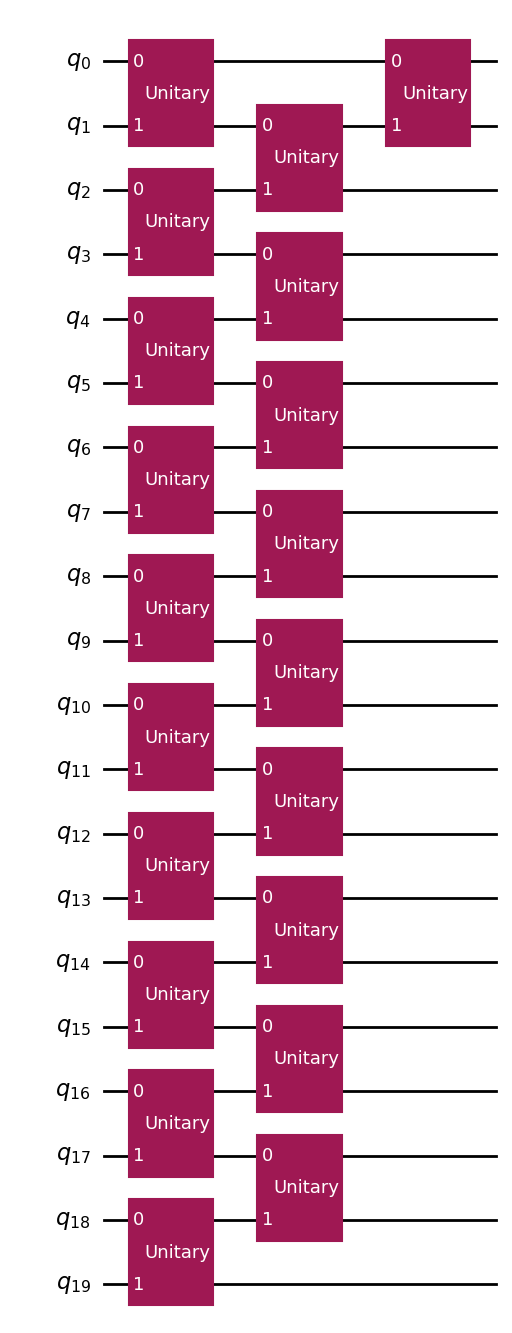

In [33]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[0,1],qc_info_Deutsch,qc_Deutsch,gate_matrix=V)
qc_info_Deutsch[-1]['layer'] = 2
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')

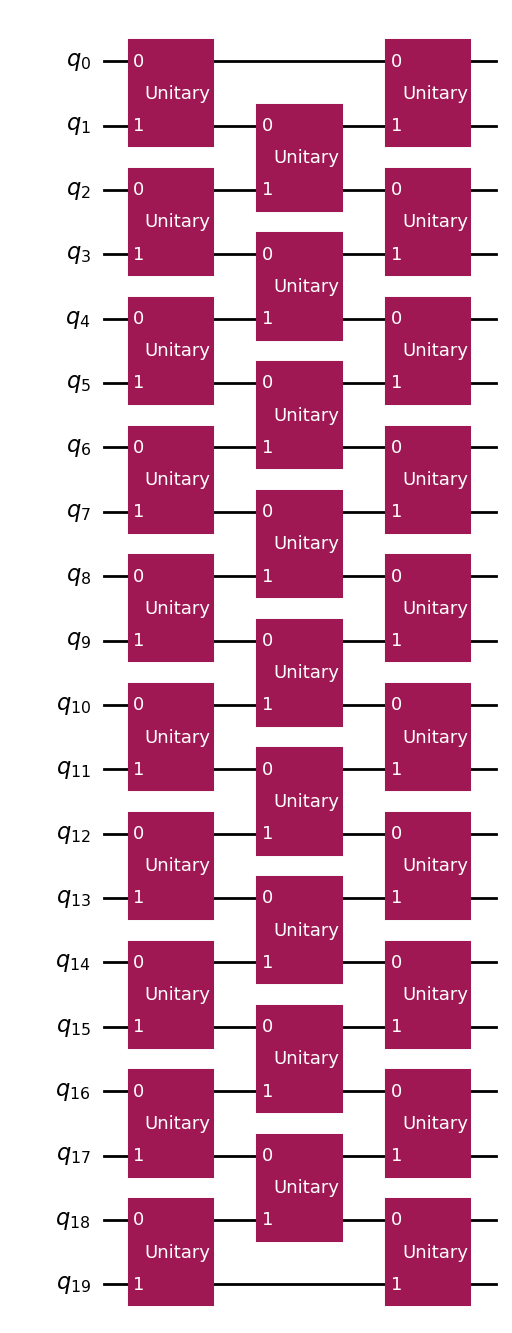

In [34]:
for i in range(1,n):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i,2*i+1],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4)) # identity gates
    qc_info_Deutsch[-1]['layer'] = 2
qc_Deutsch.draw('mpl')

## Layer 4, Control-W

{'qubits': [1, 2], 'type': 'unitary', 'matrix': [[(1+0j), 0j, 0j, 0j], [0j, (0.33786920143207105+0.9411930740946061j), 0j, 0j], [0j, 0j, (1+0j), 0j], [0j, 0j, 0j, (0.33786920143207105-0.9411930740946061j)]], 'layer': 3}


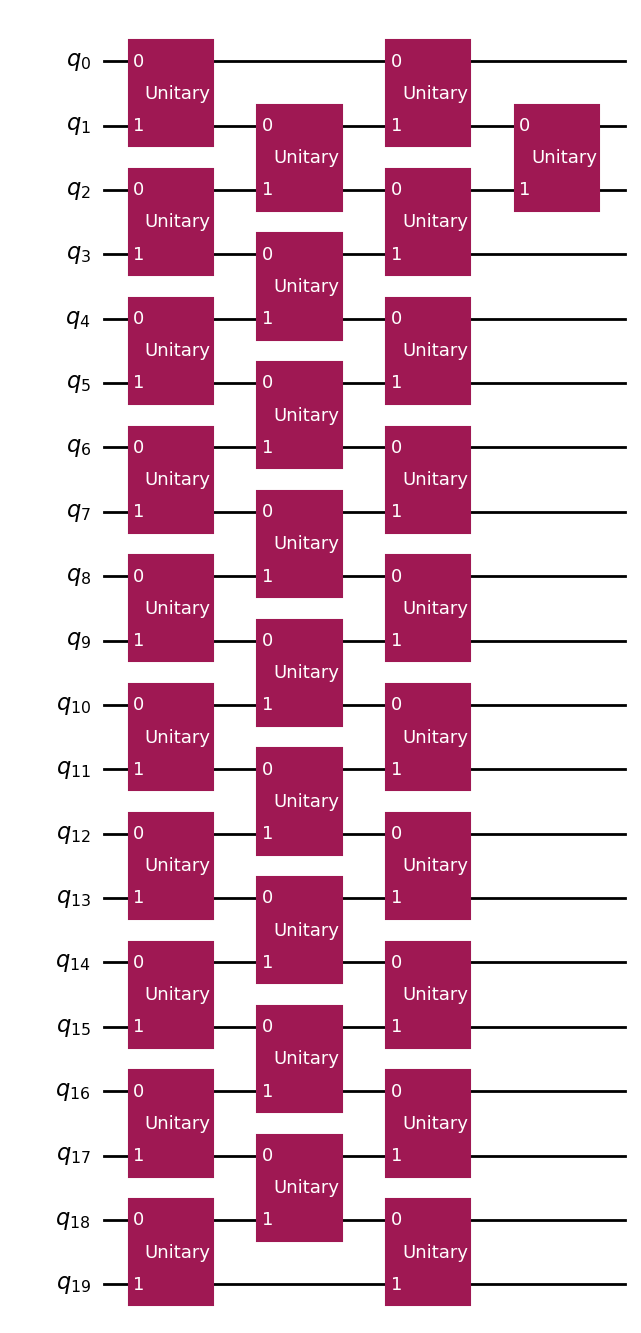

In [35]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[1,2],qc_info_Deutsch,qc_Deutsch,gate_matrix=control_W)
qc_info_Deutsch[-1]['layer'] = 3
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')

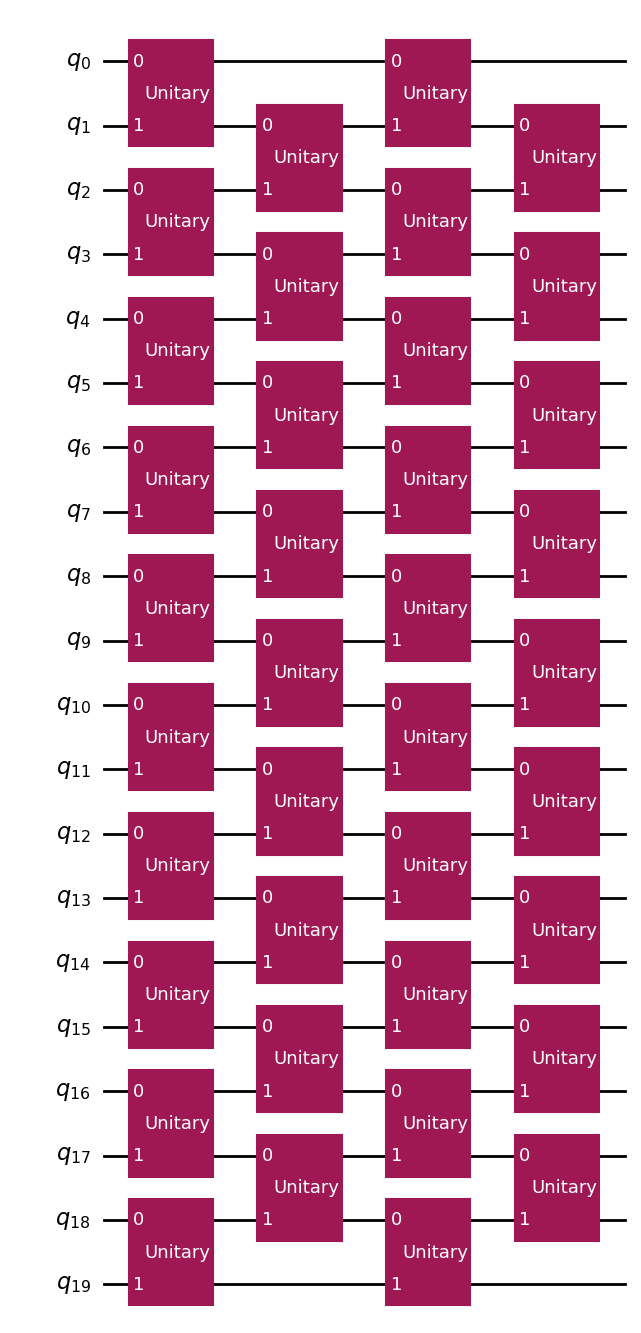

In [36]:
for i in range(1,n-1):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i+1,2*i+2],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4)) # Add identity gates
    qc_info_Deutsch[-1]['layer'] = 3
qc_Deutsch.draw('mpl')

## Layer 4: the final one. We add the 3-qubit gate $CCU^\dagger$

{'qubits': [0, 1, 2], 'type': 'unitary', 'matrix': [[(1-0j), -0j, -0j, -0j, -0j, -0j, -0j, -0j], [-0j, (1-0j), -0j, -0j, -0j, -0j, -0j, -0j], [-0j, -0j, (1-0j), -0j, -0j, -0j, -0j, -0j], [-0j, -0j, -0j, (1-0j), -0j, -0j, -0j, -0j], [-0j, -0j, -0j, -0j, (1-0j), -0j, -0j, -0j], [-0j, -0j, -0j, -0j, -0j, (-0.7716888054473092-0.6360003046754812j), -0j, -0j], [-0j, -0j, -0j, -0j, -0j, -0j, (1-0j), -0j], [-0j, -0j, -0j, -0j, -0j, -0j, -0j, (-0.7716888054473092+0.6360003046754812j)]], 'layer': 4}


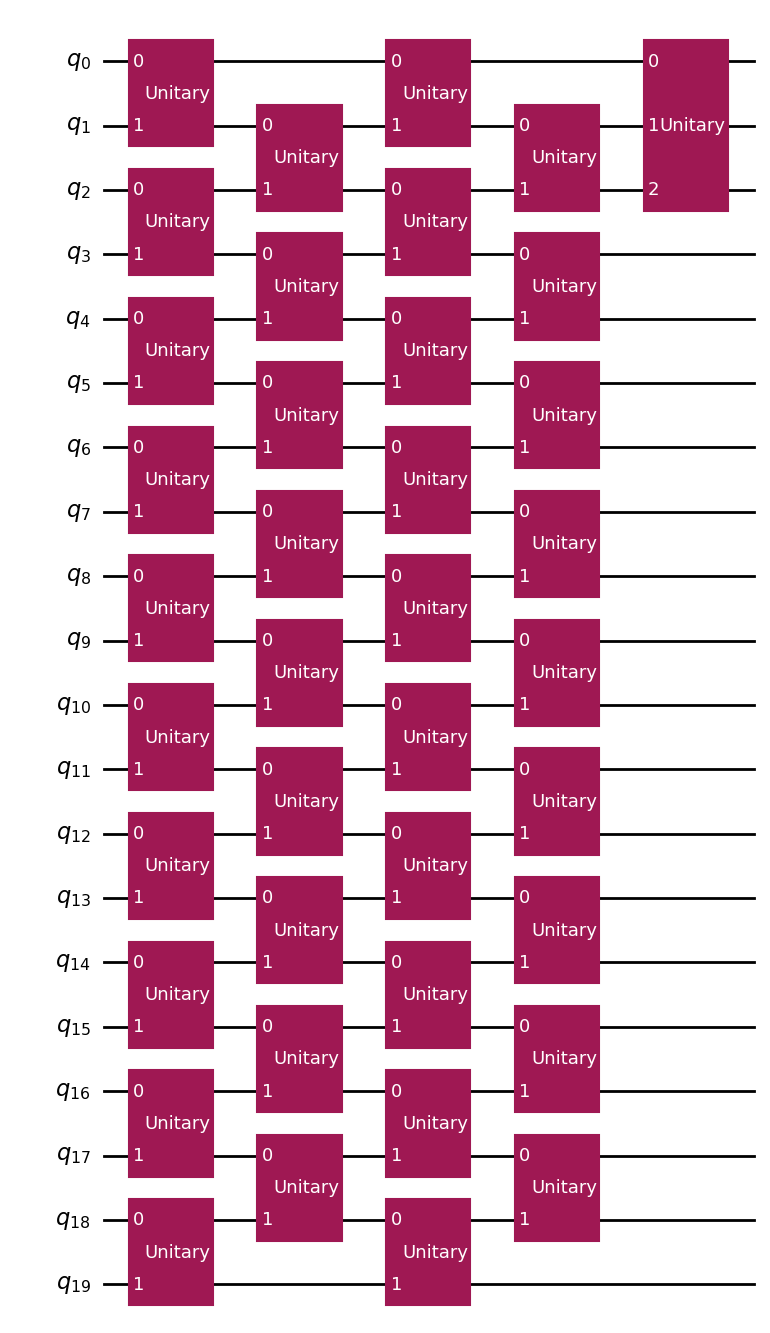

In [37]:
qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[0,1,2],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.transpose(np.conjugate(CCU)))
qc_info_Deutsch[-1]['layer'] = 4
print(qc_info_Deutsch[-1])
qc_Deutsch.draw('mpl')

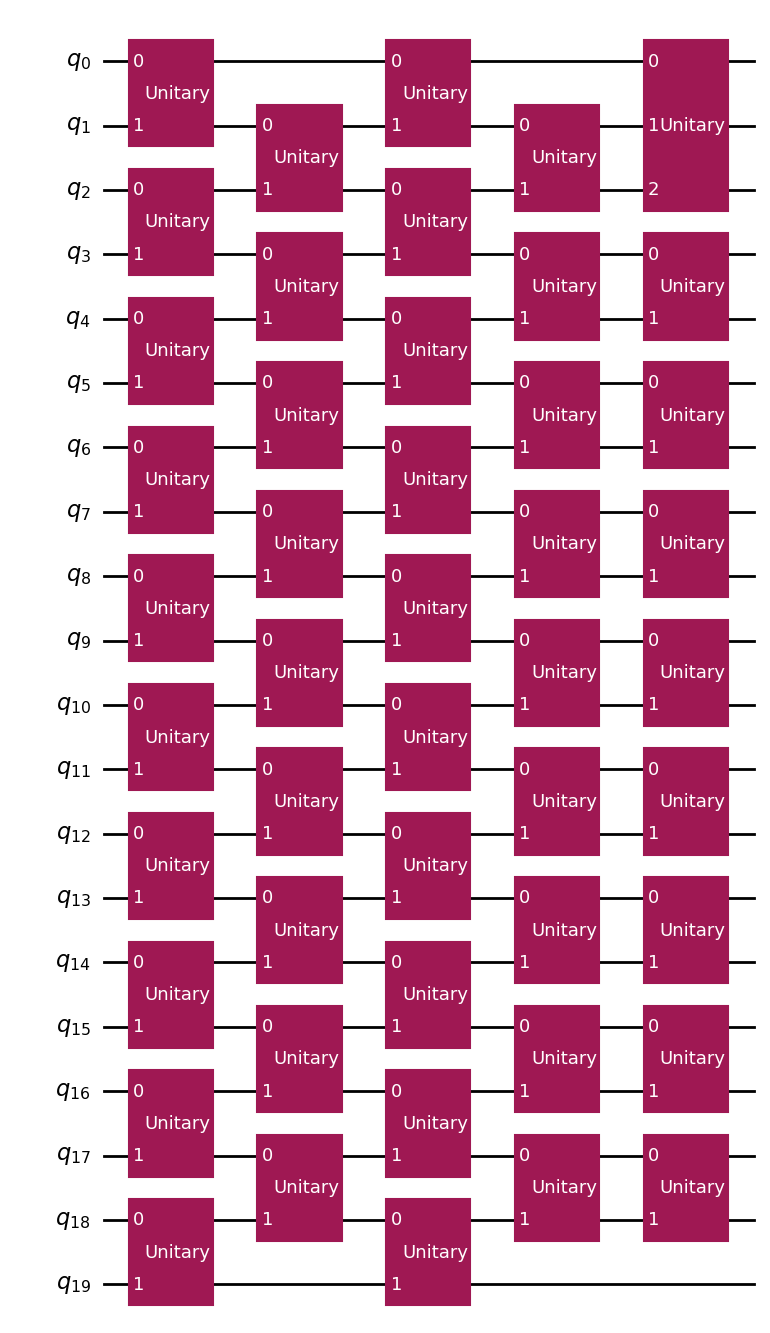

In [38]:
for i in range(1,n-1):
    qc_Deutsch, qc_info_Deutsch = Create_quantum_circuit.add_gate("unitary",[2*i+1,2*i+2],qc_info_Deutsch,qc_Deutsch,gate_matrix=np.eye(4))
    qc_info_Deutsch[-1]['layer'] = 4
qc_Deutsch.draw('mpl')

## Now, we compute local projection

In [39]:
local_projection = local_projection_computation.compute_local_projections_fullly_general(qc_info_Deutsch,n_qubits=2*n,depth = 5)
# print(local_projection)

## Checking weak equivalence now

In [40]:
check = True
count = 0
tolerance = 1e-15  # Define a tolerance for numerical comparisons
for entry in (local_projection):
    local_proj = entry['local_projection']
    # print(local_proj)
    count += 1
    # print(count)
    # Create the target eigenvector
    target_eigenvector = np.zeros(local_proj.shape[0], dtype=np.complex128)
    target_eigenvector[0] = 1  # (1, 0, 0, ..., 0)
    projection_result = local_proj @ target_eigenvector
    # print("projection_result:",projection_result)
    if np.linalg.norm(projection_result-target_eigenvector,ord=1)>local_proj.shape[0]*tolerance:
        check = False
        break

# If all checks pass
if check == True:
    print("All local_projections in local_projection_2 have (1, 0, 0, ..., 0) as an eigenvector with eigenvalue 1.")
    print("Number of entries in local_projection:", count)
    print("Checking successfull.")   
else:
    print("Not all local projections are correct.")
    print("Number of entries in local_projection:", count)
    print("Checking failed.")

All local_projections in local_projection_2 have (1, 0, 0, ..., 0) as an eigenvector with eigenvalue 1.
Number of entries in local_projection: 10
Checking successfull.


## Now, we compute Choi local projection

In [41]:
Choi_local_projection = Checking_Equivalence_with_Choi.compute_local_projections_with_Choi_isomorphism(qc_info_Deutsch,20,5)
# compute_local_projections_with_Choi_isomorphism_efficient(qc_info_Deutsch,20,5)
# np.savetxt("large_matrix.txt", Choi_isomorphism_projection[0]['local_projection'], fmt="%.3f")

0
1
2
3
4


## Now, checking Equivalence

In [42]:
EPR_projector_AB = 1/2 * np.array([[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]], dtype=np.complex128)
check = True
count = 0
tolerance = 1e-15  # Define a tolerance for numerical comparisons
for entry in (Choi_local_projection):
    print(entry["qubit_indices"])
    print(entry['initial_qubit'])
    count+=1
    structure = Checking_Equivalence_with_Choi.find_position_of_initial_qubit_in_entry(entry)
    print(structure)  # Get the positions before and after the qubit
    test_density_matrix = EPR_projector_AB
    test_density_matrix = Checking_Equivalence_with_Choi.reconstruct_matrix_M_ACB(EPR_projector_AB, np.eye(2**structure[0]))
    test_density_matrix = np.kron(test_density_matrix, np.eye(2**structure[1]))

        # Compute the image after applying the local projection
    image = entry['local_projection'] @ test_density_matrix
        
    # Compare the resulting matrix with the original test_density_matrix

    if np.linalg.norm(image-test_density_matrix,ord=1)>image.shape[0]*tolerance:
        check = False
        break

# If all checks pass
if check == True:
    print("Number of entries in local_projection:", count)
    print("Checking successfull.")   
else:
    print("Not all local projections are correct.")
    print("Number of entries in local_projection:", count)
    print("Checking failed.")

[0, 1, 2, 3, 4]
0
(0, 4)
[0, 1, 2, 3, 4, 5, 6]
2
(2, 4)
[0, 1, 2, 3, 4, 5, 6, 7, 8]
4
(4, 4)
[3, 4, 5, 6, 7, 8, 9, 10]
6
(3, 4)
[5, 6, 7, 8, 9, 10, 11, 12]
8
(3, 4)
[7, 8, 9, 10, 11, 12, 13, 14]
10
(3, 4)
[9, 10, 11, 12, 13, 14, 15, 16]
12
(3, 4)
[11, 12, 13, 14, 15, 16, 17, 18]
14
(3, 4)
[13, 14, 15, 16, 17, 18, 19]
16
(3, 3)
[15, 16, 17, 18, 19]
18
(3, 1)
Number of entries in local_projection: 10
Checking successfull.
